# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

## Imports

In [1]:
import math
import os
import tempfile
import random

import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [33]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-r0mlvvnn/granite-tsfm_eebb9e106a324b64ab0071c5c314dd13
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-r0mlvvnn/granite-tsfm_eebb9e106a324b64ab0071c5c314dd13
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "PSM2"
dataset_path = "Datasets/TSB-AD-M/115_PSM_id_1_Facility_tr_50000_1st_129872.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [5]:
# Dataset
TARGET_DATASET = "PSM2"
dataset_path = "Datasets/TSB-AD-M/115_PSM_id_1_Facility_tr_50000_1st_129872.csv"
timestamp_column = None
id_columns = []

data = pd.read_csv(dataset_path).iloc[120001:140000]
target_columns = data.columns[:-1].tolist()

num_rows = data.shape[0]
split_config = {
    "train": [0, int(0.8 * num_rows)],
    "valid": [int(0.8 * num_rows), int(0.9 * num_rows)],
    "test": [int(0.9 * num_rows), num_rows],
}

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [6]:
(data['Label'] == 1).sum()

1173

## Zero-shot evaluation method

In [72]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    #valid_indices = random.sample(range(len(dset_test)), k=min(9, len(dset_test)))

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

# Zeroshot

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.24712394177913666, 'eval_runtime': 51.1475, 'eval_samples_per_second': 37.245, 'eval_steps_per_second': 37.245}
(1905, 96, 25)
(1905, 25, 8, 192)


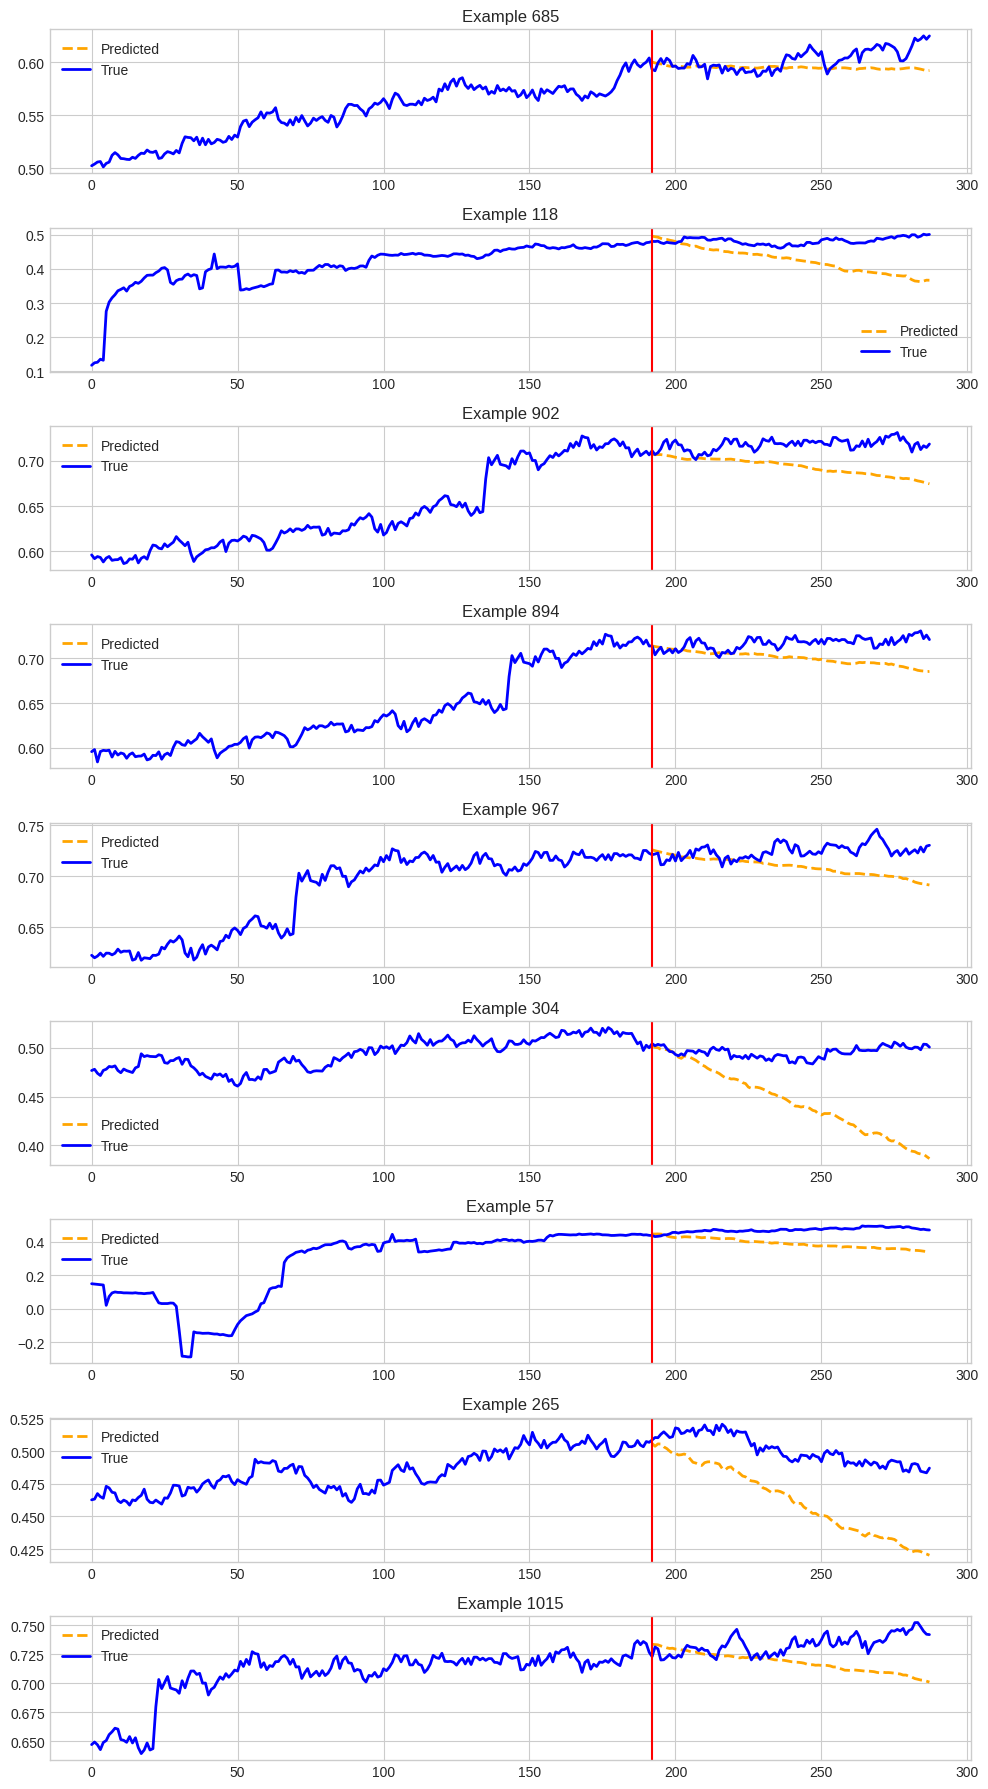

In [73]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=1
)

 ## Few-shot finetune and evaluation method

In [74]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    #valid_indices = random.sample(range(len(dset_test)), k=min(9, len(dset_test)))

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Checkpoint destination directory ttm_finetuned_models/PSM2/output/checkpoint-22 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[TrackingCallback] Mean Epoch Time = 7.672548810640971 seconds, Total Train Time = 216.0118796825409
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.243581622838974, 'eval_runtime': 10.1963, 'eval_samples_per_second': 186.832, 'eval_steps_per_second': 2.942, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


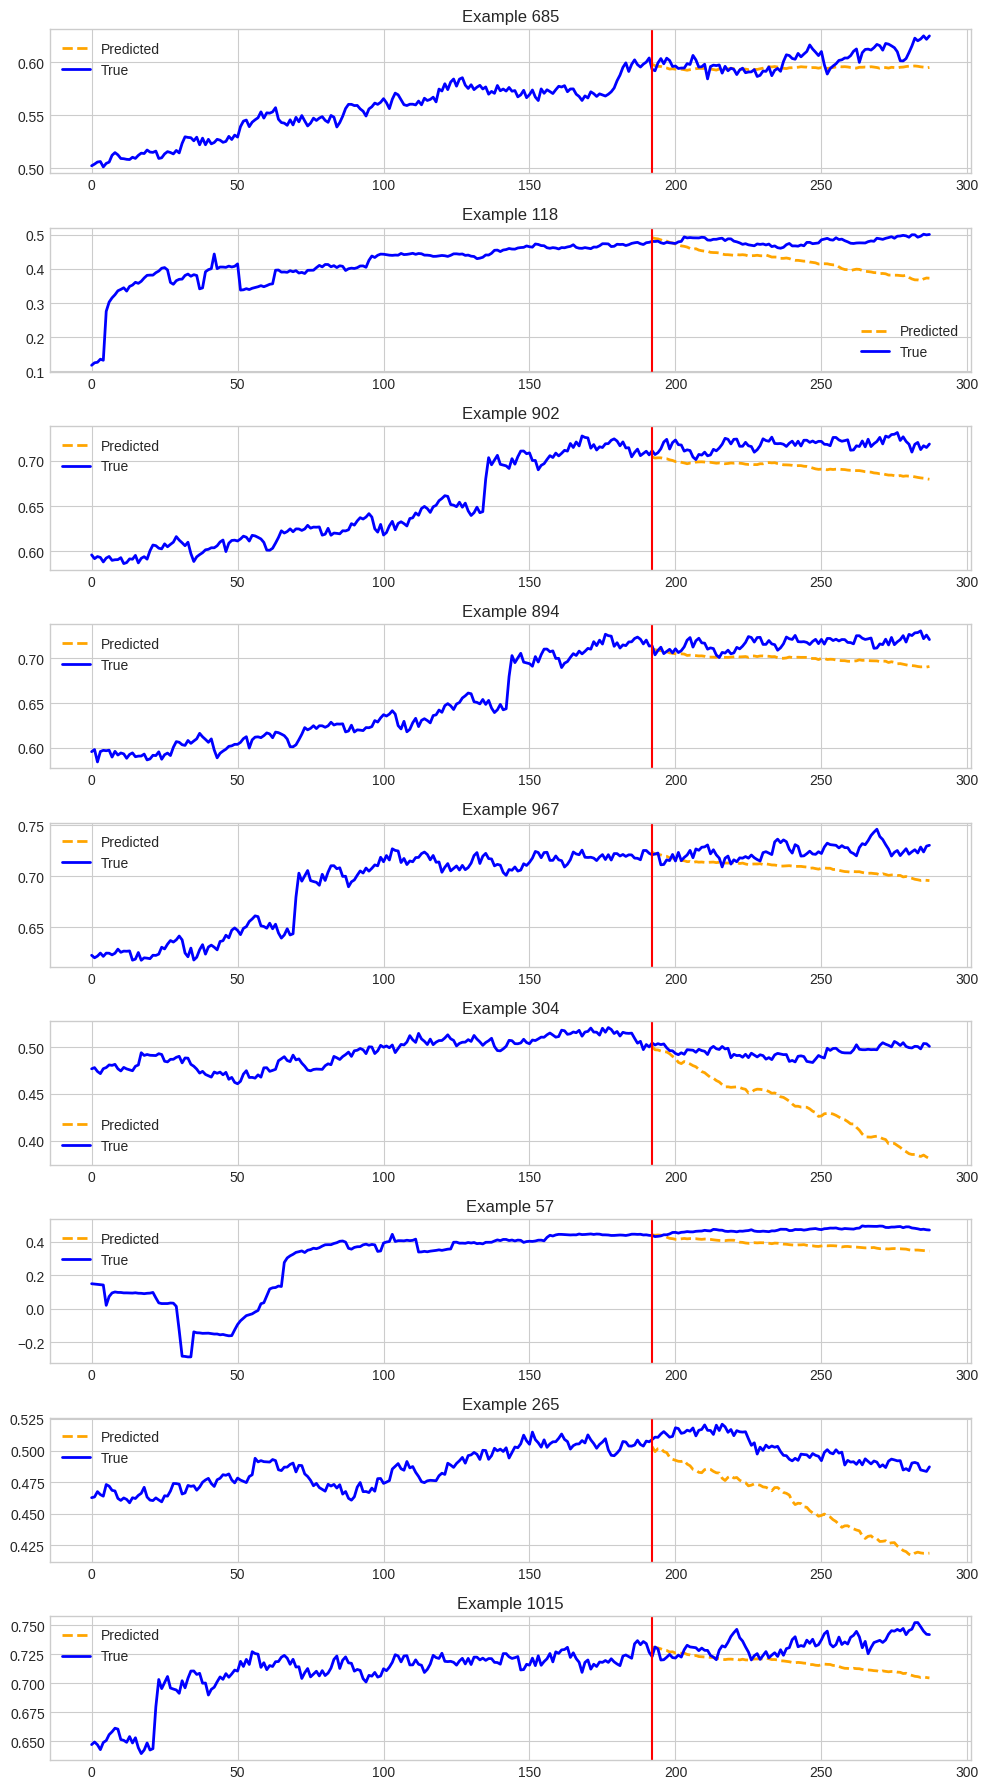

In [76]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 30% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 51.2137243530967 seconds, Total Train Time = 684.3072996139526
++++++++++++++++++++ Test MSE after few-shot 30% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.21922415494918823, 'eval_runtime': 10.4796, 'eval_samples_per_second': 181.781, 'eval_steps_per_second': 2.863, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


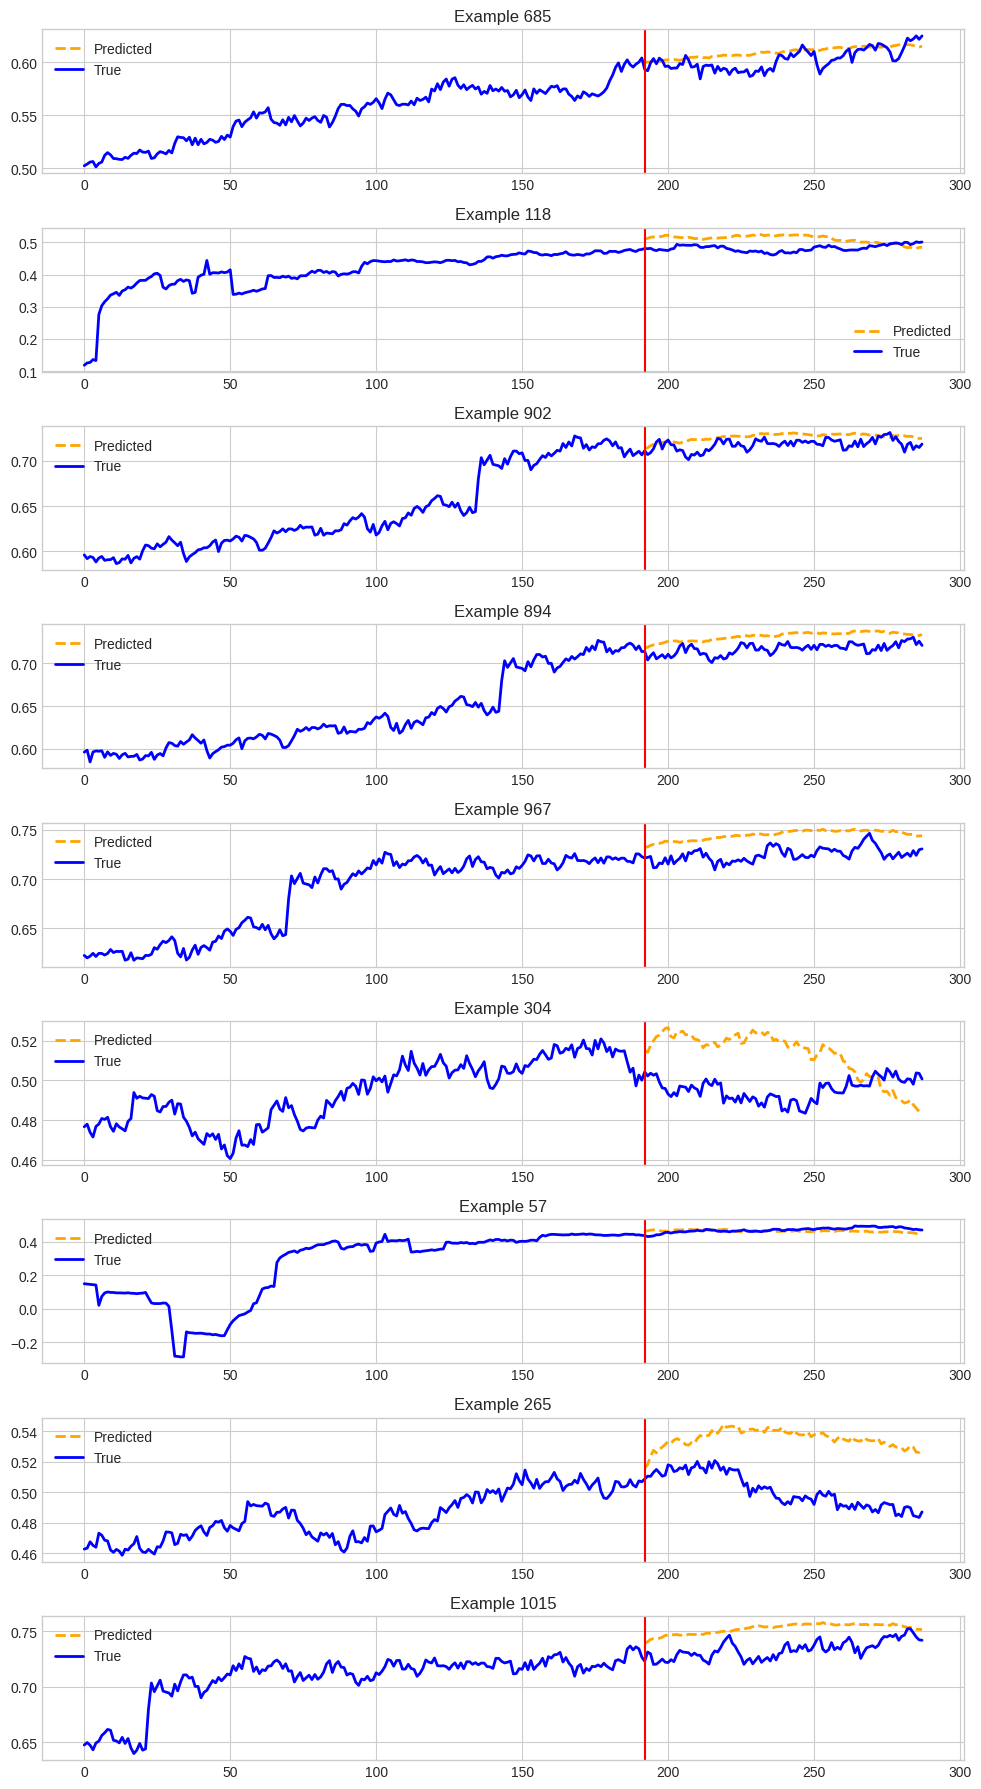

In [77]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=30,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 50% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 74.40853842821988 seconds, Total Train Time = 928.8448674678802
++++++++++++++++++++ Test MSE after few-shot 50% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2150779515504837, 'eval_runtime': 10.2498, 'eval_samples_per_second': 185.857, 'eval_steps_per_second': 2.927, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


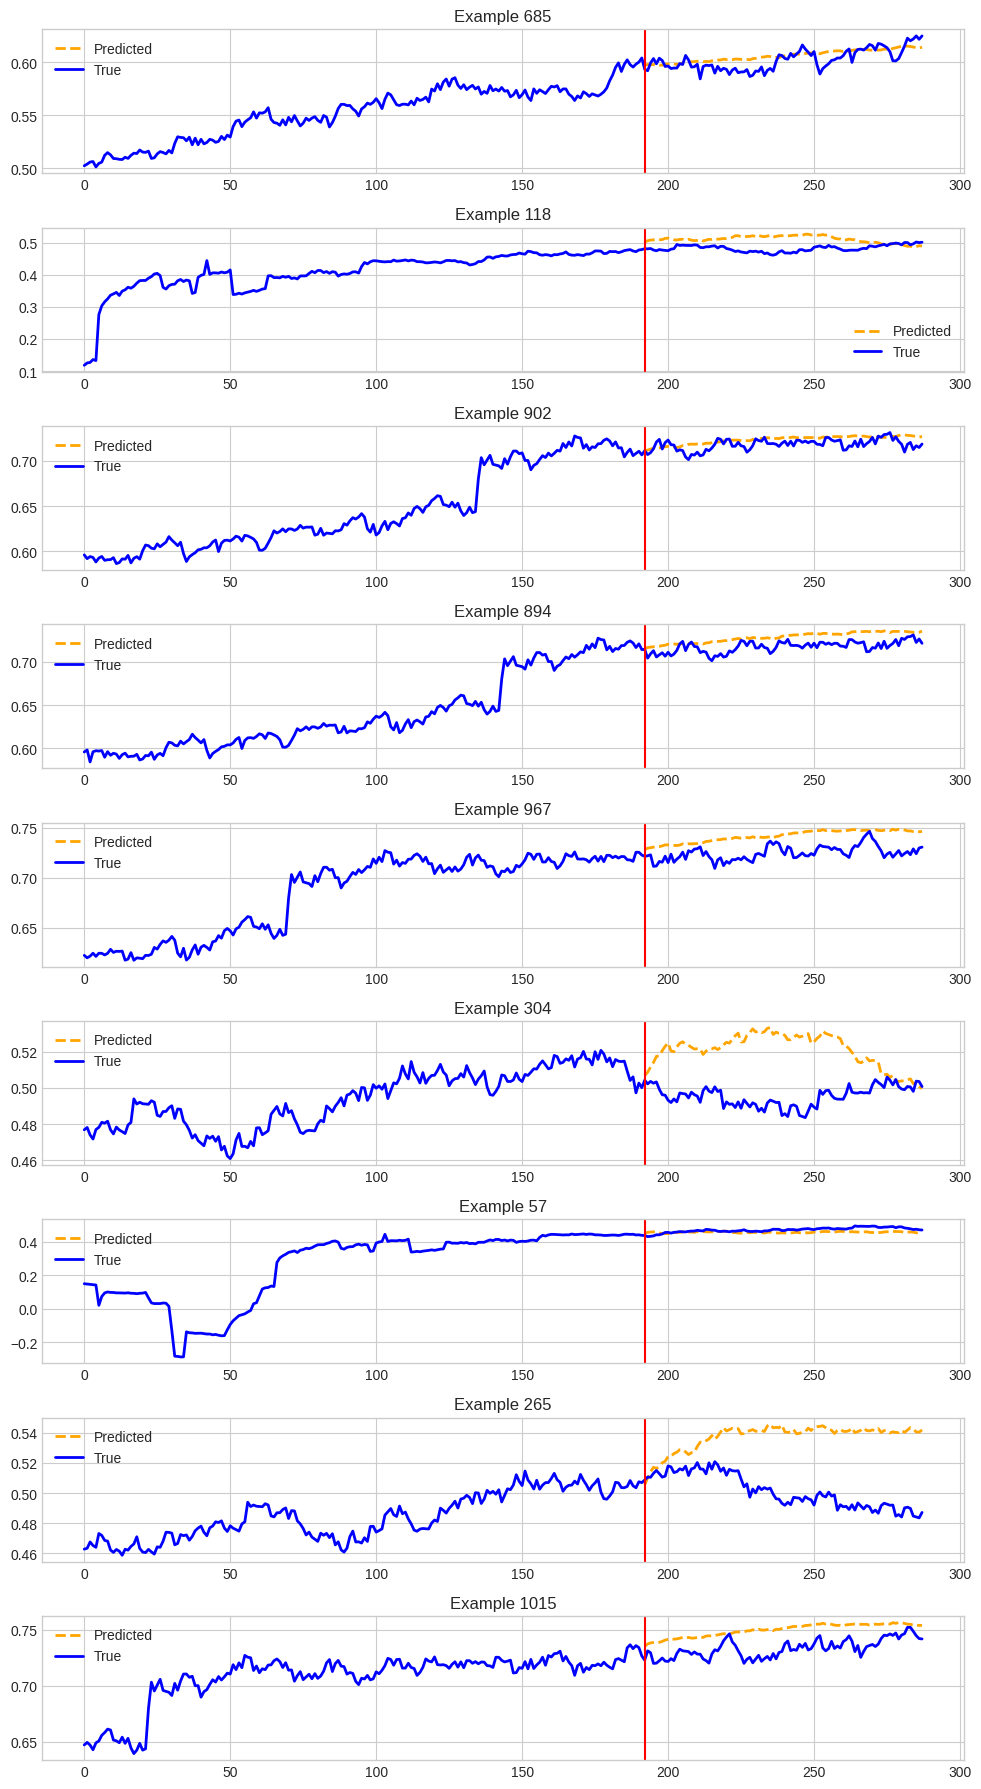

In [78]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=50,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 80% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 112.07381144436923 seconds, Total Train Time = 1340.5106670856476
++++++++++++++++++++ Test MSE after few-shot 80% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2153206616640091, 'eval_runtime': 9.8071, 'eval_samples_per_second': 194.247, 'eval_steps_per_second': 3.059, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


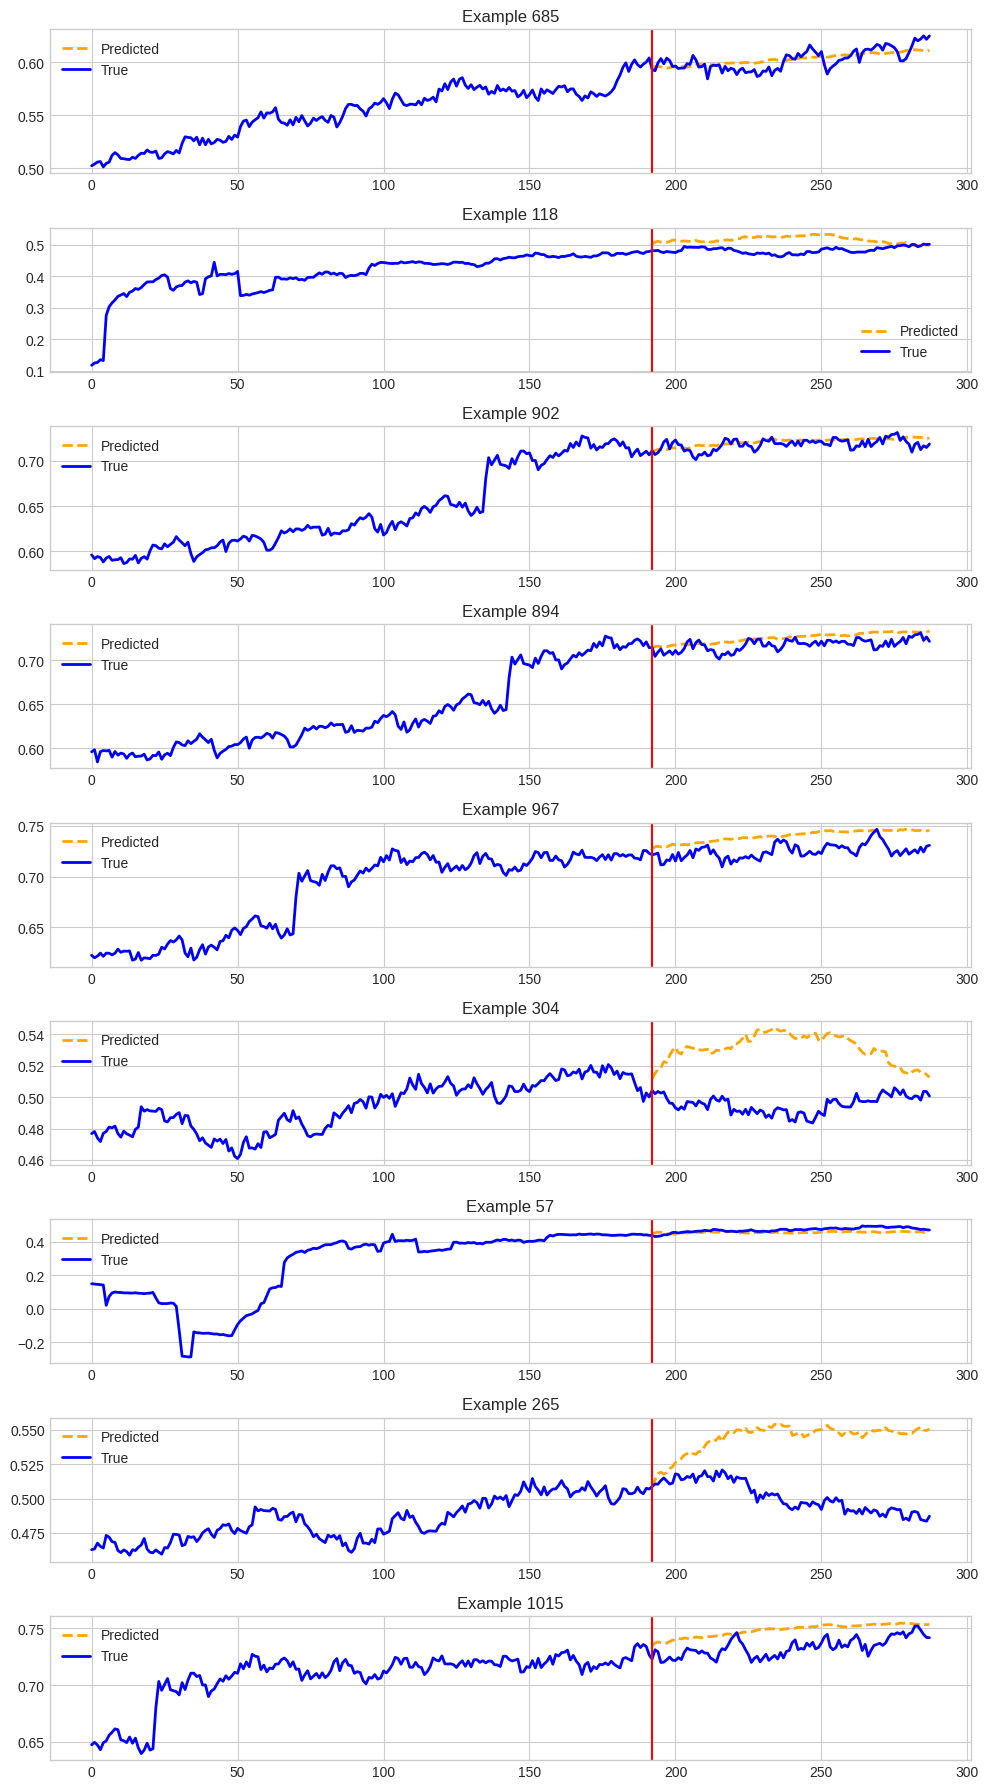

In [79]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=80,
    learning_rate=0.001,
)

In [7]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=False,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    # Extract predictions
    if isinstance(predictions_dict.predictions, (list, tuple)) and len(predictions_dict.predictions) >= 1:
        preds = predictions_dict.predictions[0]
        if isinstance(preds, torch.Tensor):
            preds = preds.detach().cpu().numpy()
    else:
        raise ValueError("No predictions found!")

    # Extract targets
    first_sample = dset_test[0]
    if isinstance(first_sample, dict):
        targets = torch.stack([sample["future_values"] for sample in dset_test])
    elif isinstance(first_sample, (tuple, list)) and len(first_sample) > 1:
        targets = torch.stack([sample[1] for sample in dset_test])
    else:
        raise ValueError("Unexpected sample format.")

    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()

    print(f"[Debug] preds shape: {preds.shape}, targets shape: {targets.shape}")

    return preds, targets


INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 13.584188634699041 seconds, Total Train Time = 259.89044427871704
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.23822695016860962, 'eval_runtime': 9.7028, 'eval_samples_per_second': 196.335, 'eval_steps_per_second': 3.092, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


[Debug] preds shape: (1905, 96, 25), targets shape: (1905, 96, 25)


(array([[[ 0.39346826, -0.8265095 , -0.96722287, ...,  0.43301463,
          -0.22406656, -0.37406385],
         [ 0.3901387 , -0.82736033, -0.9653885 , ...,  0.46130335,
          -0.27446455, -0.33381045],
         [ 0.38517657, -0.82770306, -0.96857035, ...,  0.4361148 ,
          -0.37169805, -0.39146852],
         ...,
         [ 0.30899864, -0.8362681 , -0.9798552 , ...,  0.33531082,
          -0.6643959 , -0.7334446 ],
         [ 0.30759206, -0.836735  , -0.97682685, ...,  0.39182556,
          -0.6833862 , -0.7611051 ],
         [ 0.30761945, -0.8366881 , -0.9788603 , ...,  0.37937438,
          -0.68313676, -0.76782286]],
 
        [[ 0.40105665, -0.8263786 , -0.9604721 , ...,  0.31001973,
          -0.02625656, -0.40323967],
         [ 0.39778388, -0.8268857 , -0.9655828 , ...,  0.3130653 ,
          -0.19202632, -0.45711774],
         [ 0.39495924, -0.8269659 , -0.96545714, ...,  0.2820778 ,
          -0.25472277, -0.47684133],
         ...,
         [ 0.3238427 , -0.836238 

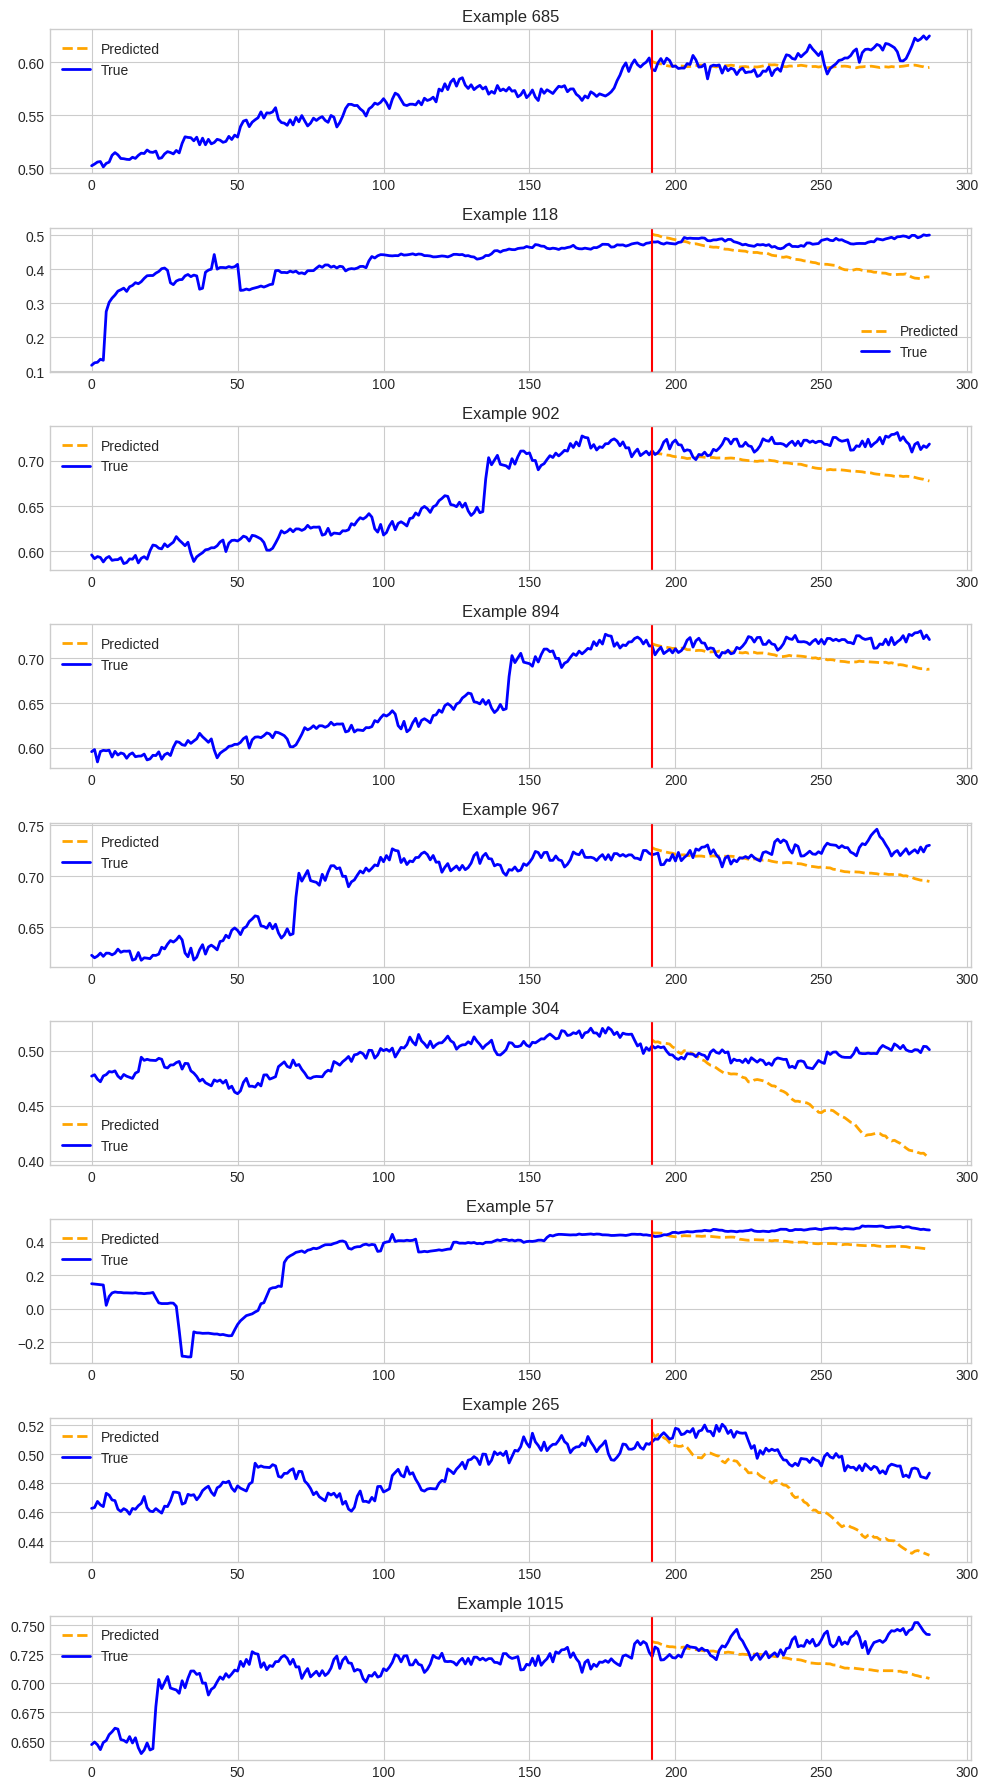

In [81]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 30% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 84.05634678493847 seconds, Total Train Time = 1034.7896523475647
++++++++++++++++++++ Test MSE after few-shot 30% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.21308137476444244, 'eval_runtime': 9.8226, 'eval_samples_per_second': 193.94, 'eval_steps_per_second': 3.054, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


[Debug] preds shape: (1905, 96, 25), targets shape: (1905, 96, 25)


(array([[[ 0.39352018, -0.8277336 , -0.9644224 , ...,  0.40537632,
          -0.17409784, -0.33465117],
         [ 0.39115208, -0.82763827, -0.9622572 , ...,  0.43844342,
          -0.19507682, -0.2711845 ],
         [ 0.38664103, -0.82730746, -0.96567357, ...,  0.42129564,
          -0.2719851 , -0.31392527],
         ...,
         [ 0.37463757, -0.8232874 , -0.9471147 , ...,  0.20730782,
          -0.3330245 , -0.24336344],
         [ 0.37258834, -0.8237591 , -0.9439302 , ...,  0.2538532 ,
          -0.34999198, -0.26368272],
         [ 0.37076354, -0.82380325, -0.945905  , ...,  0.23666084,
          -0.34911895, -0.25747925]],
 
        [[ 0.3988753 , -0.82793593, -0.95762527, ...,  0.2917719 ,
           0.04766107, -0.37138855],
         [ 0.39620852, -0.8275358 , -0.96248084, ...,  0.29704273,
          -0.07396322, -0.40153503],
         [ 0.39364862, -0.826975  , -0.96218055, ...,  0.2727269 ,
          -0.11000597, -0.4074546 ],
         ...,
         [ 0.3869319 , -0.8233671

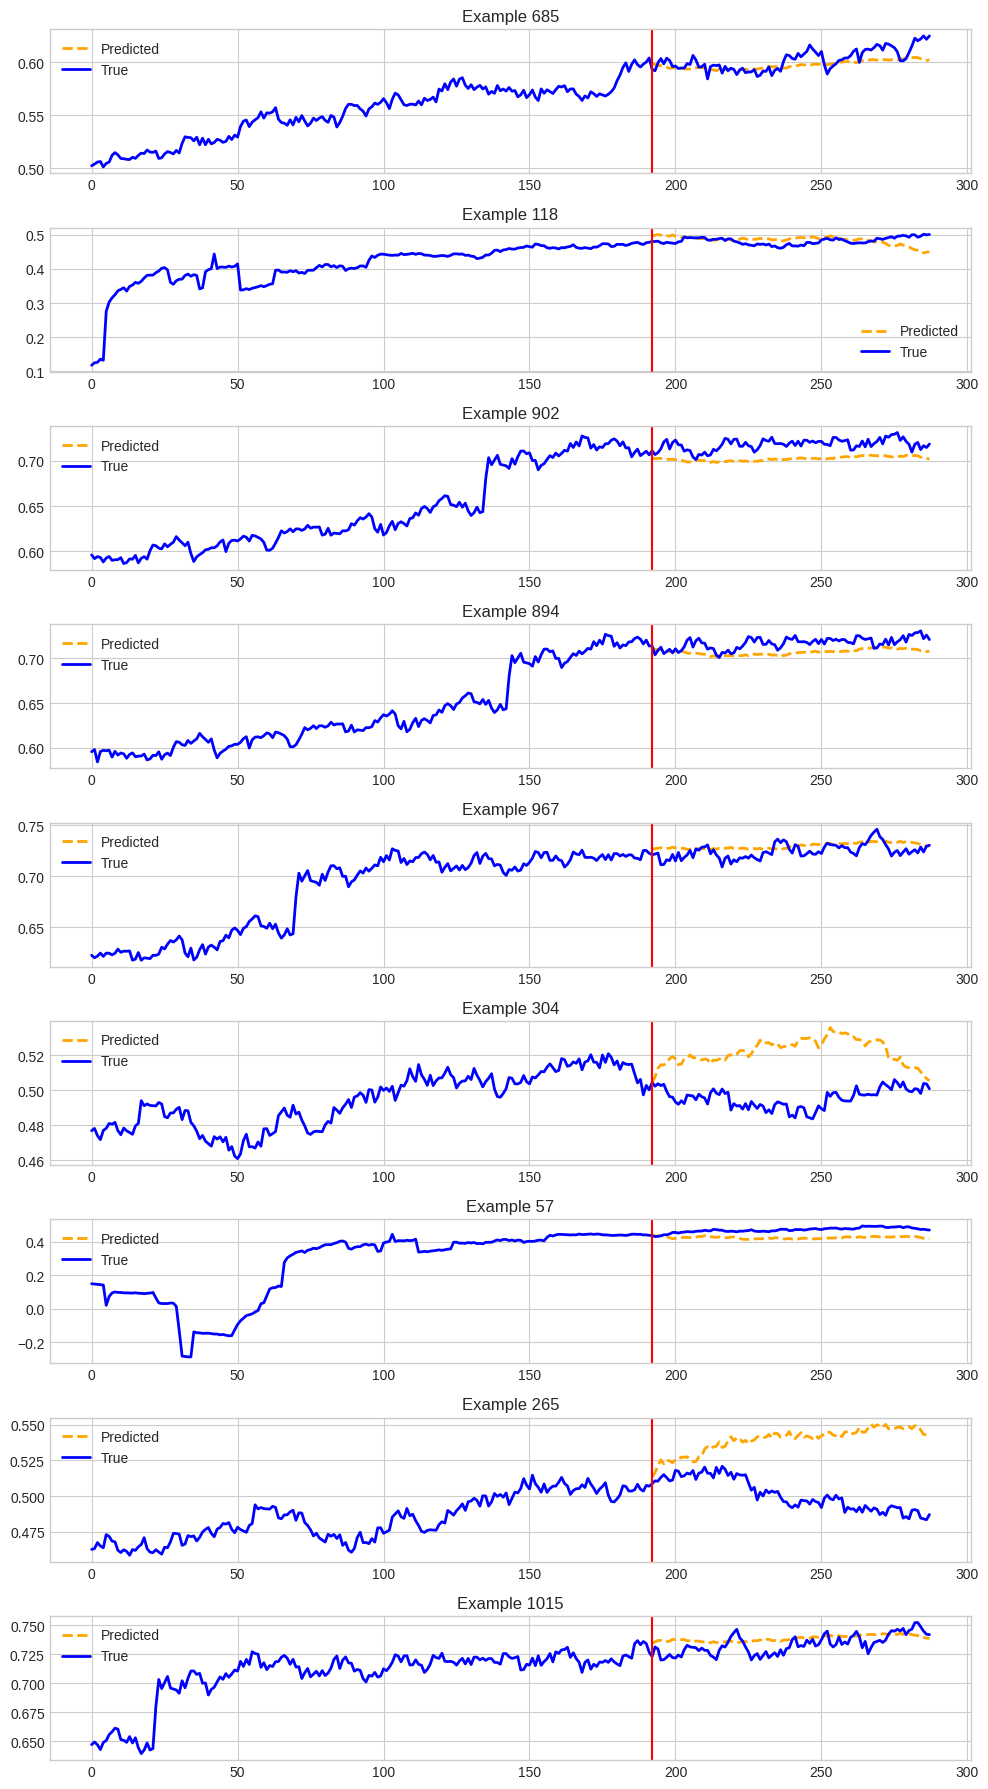

In [82]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=30,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 50% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 141.9711630777879 seconds, Total Train Time = 1671.5038313865662
++++++++++++++++++++ Test MSE after few-shot 50% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.21242938935756683, 'eval_runtime': 9.7043, 'eval_samples_per_second': 196.305, 'eval_steps_per_second': 3.091, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


[Debug] preds shape: (1905, 96, 25), targets shape: (1905, 96, 25)


(array([[[ 0.3997558 , -0.8262072 , -0.9623635 , ...,  0.39396298,
          -0.17028761, -0.33408678],
         [ 0.39768973, -0.8262541 , -0.95865536, ...,  0.43549573,
          -0.18847805, -0.2666282 ],
         [ 0.3935244 , -0.826111  , -0.9614332 , ...,  0.41826284,
          -0.26096672, -0.30240566],
         ...,
         [ 0.37497512, -0.82417685, -0.9389931 , ...,  0.21731102,
          -0.28361684, -0.17600328],
         [ 0.37415385, -0.82453823, -0.9352096 , ...,  0.26380455,
          -0.29935205, -0.193008  ],
         [ 0.37322867, -0.824402  , -0.93771756, ...,  0.24188423,
          -0.2996511 , -0.18719804]],
 
        [[ 0.40502626, -0.8263227 , -0.9551273 , ...,  0.29379785,
           0.05937999, -0.3718208 ],
         [ 0.4025104 , -0.8260576 , -0.9580147 , ...,  0.30741596,
          -0.05785233, -0.39656222],
         [ 0.4001794 , -0.82569164, -0.95734876, ...,  0.28365445,
          -0.08998704, -0.39536637],
         ...,
         [ 0.38673985, -0.8241129

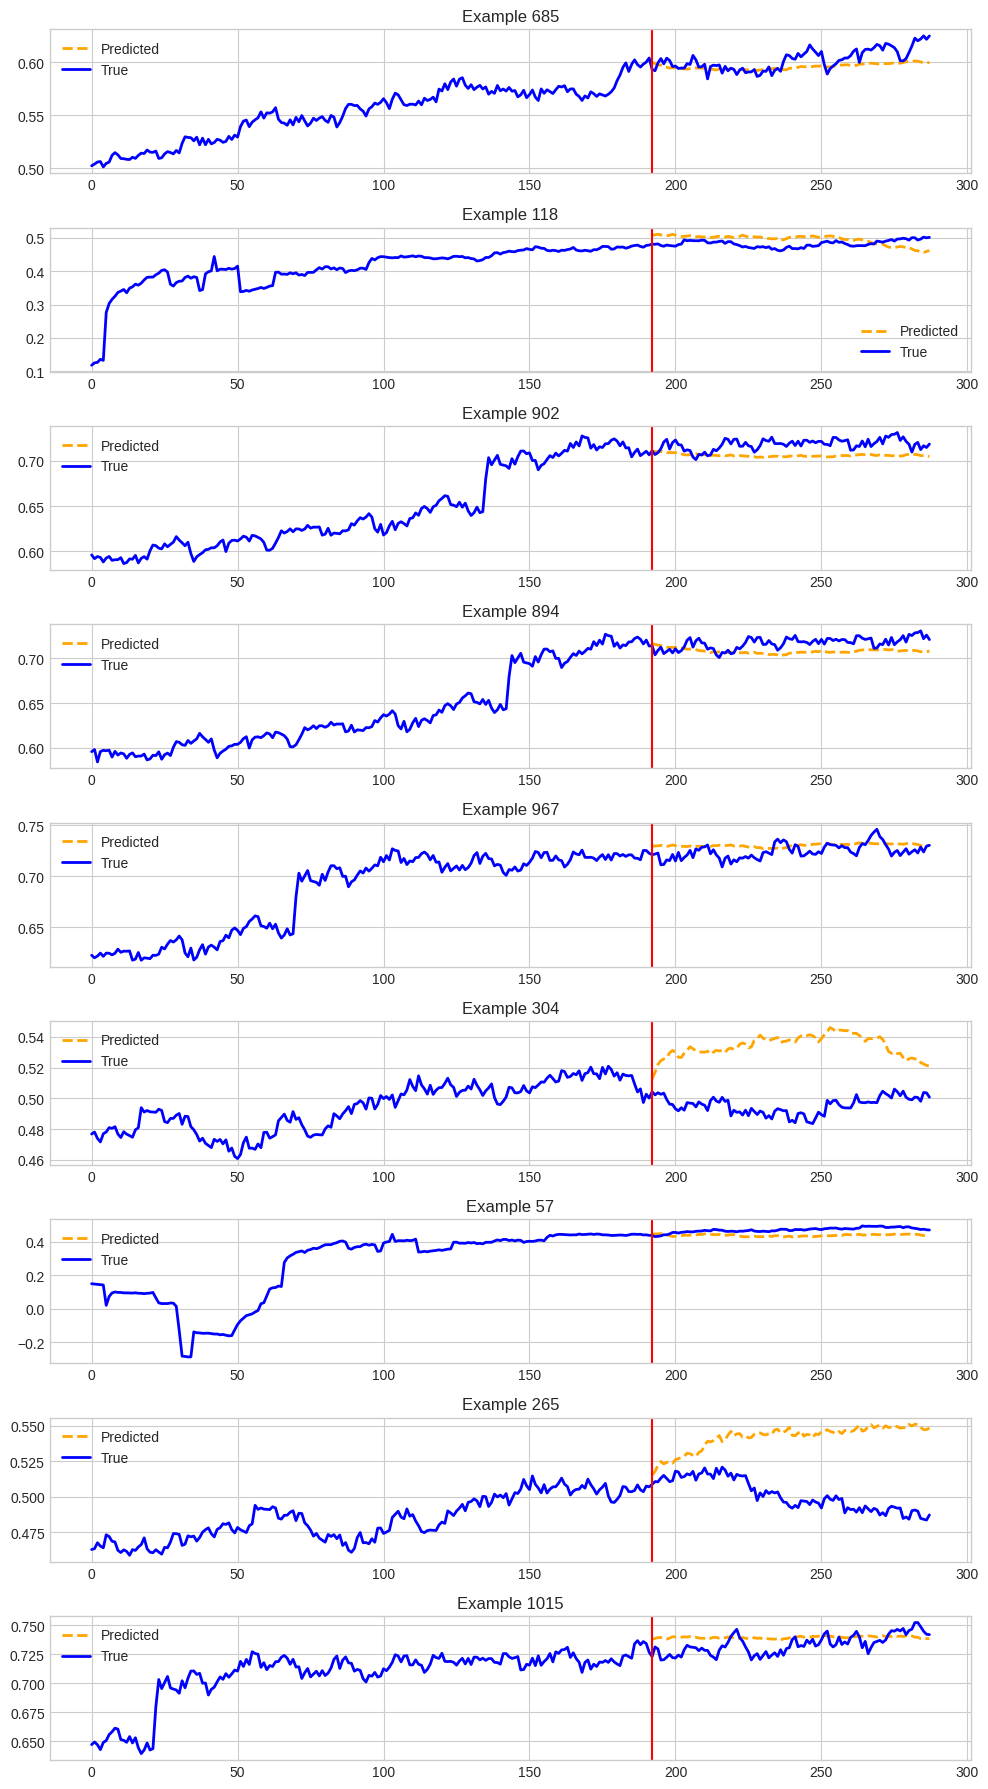

In [83]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=50,
    learning_rate=0.001,
)

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=80,
    learning_rate=0.001,
)

INFO:p-30167:t-129979547536256:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 80% --------------------


INFO:p-30167:t-129979547536256:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-30167:t-129979547536256:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)


INFO:p-10215:t-129746807798656:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-10215:t-129746807798656:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-10215:t-129746807798656:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 1.0648563901583354 seconds, Total Train Time = 25.97574234008789
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 1.3819373846054077, 'eval_runtime': 1.0556, 'eval_samples_per_second': 1804.718, 'eval_steps_per_second': 28.421, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


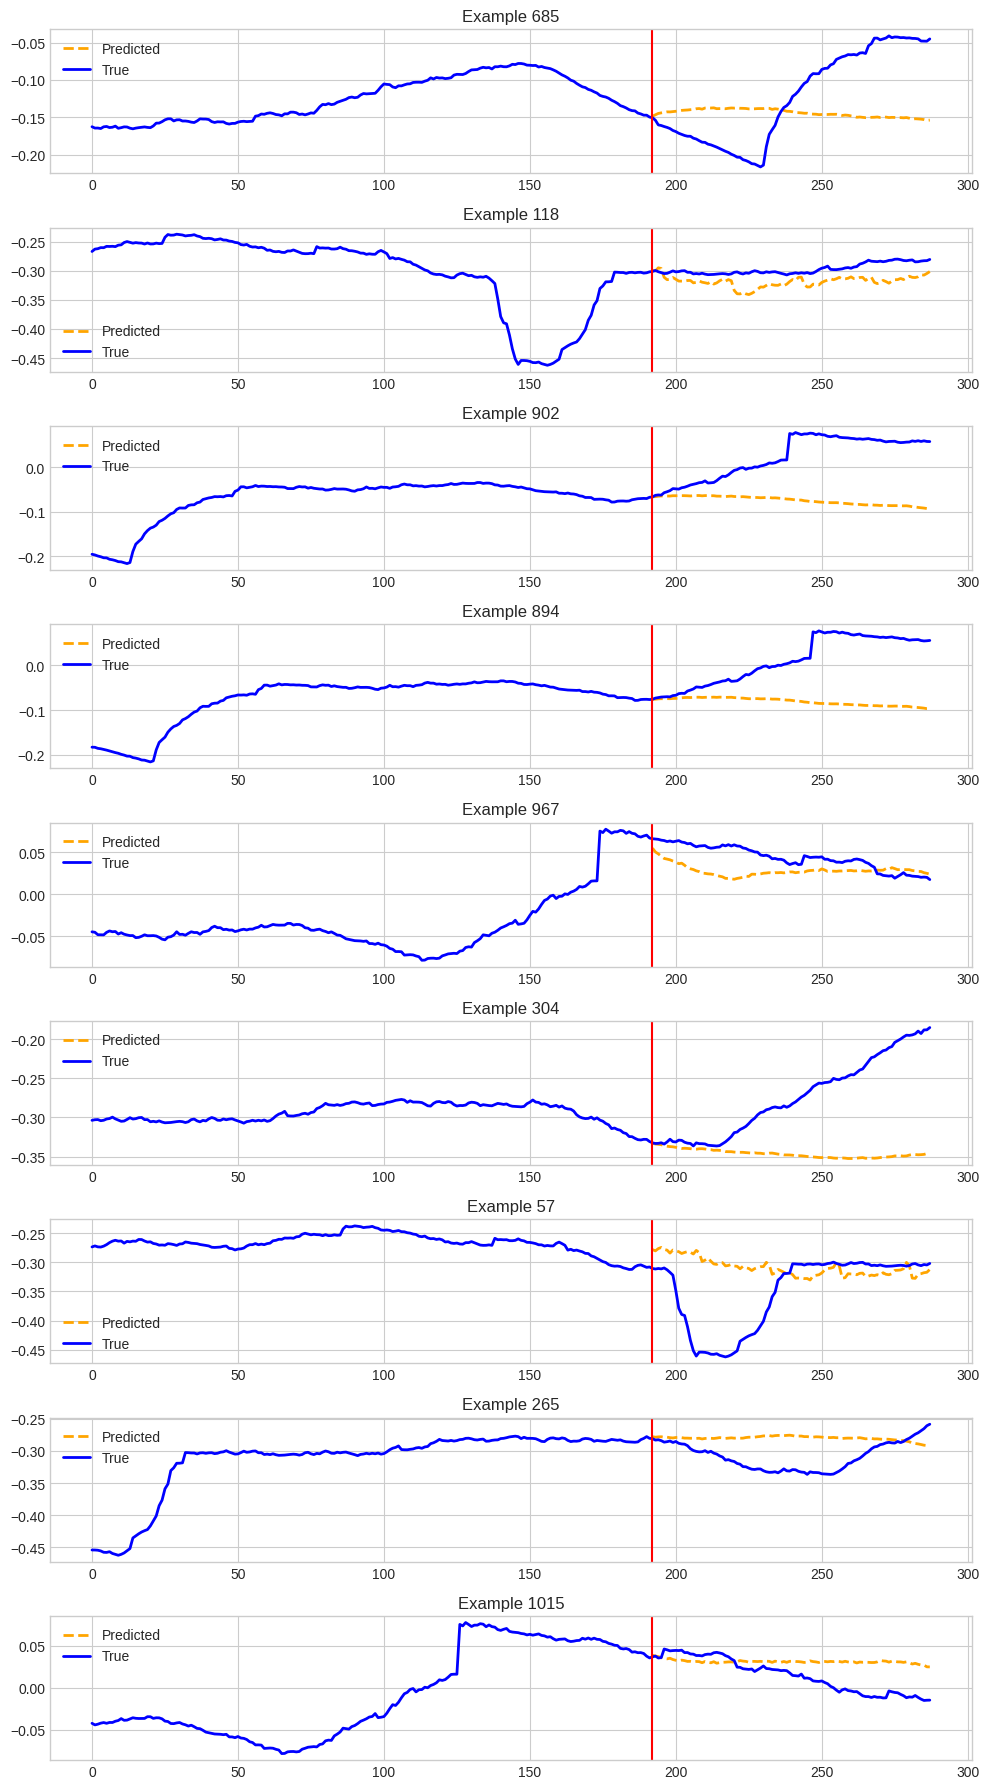

In [22]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

INFO:p-10215:t-129746807798656:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-10215:t-129746807798656:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1024-96-r2.
INFO:p-10215:t-129746807798656:get_model.py:get_model:[TTM] context_length = 1024, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.8318035006523132, 'eval_runtime': 2.51, 'eval_samples_per_second': 778.092, 'eval_steps_per_second': 12.351}
(1953, 48, 25)
(1953, 25, 8, 384)


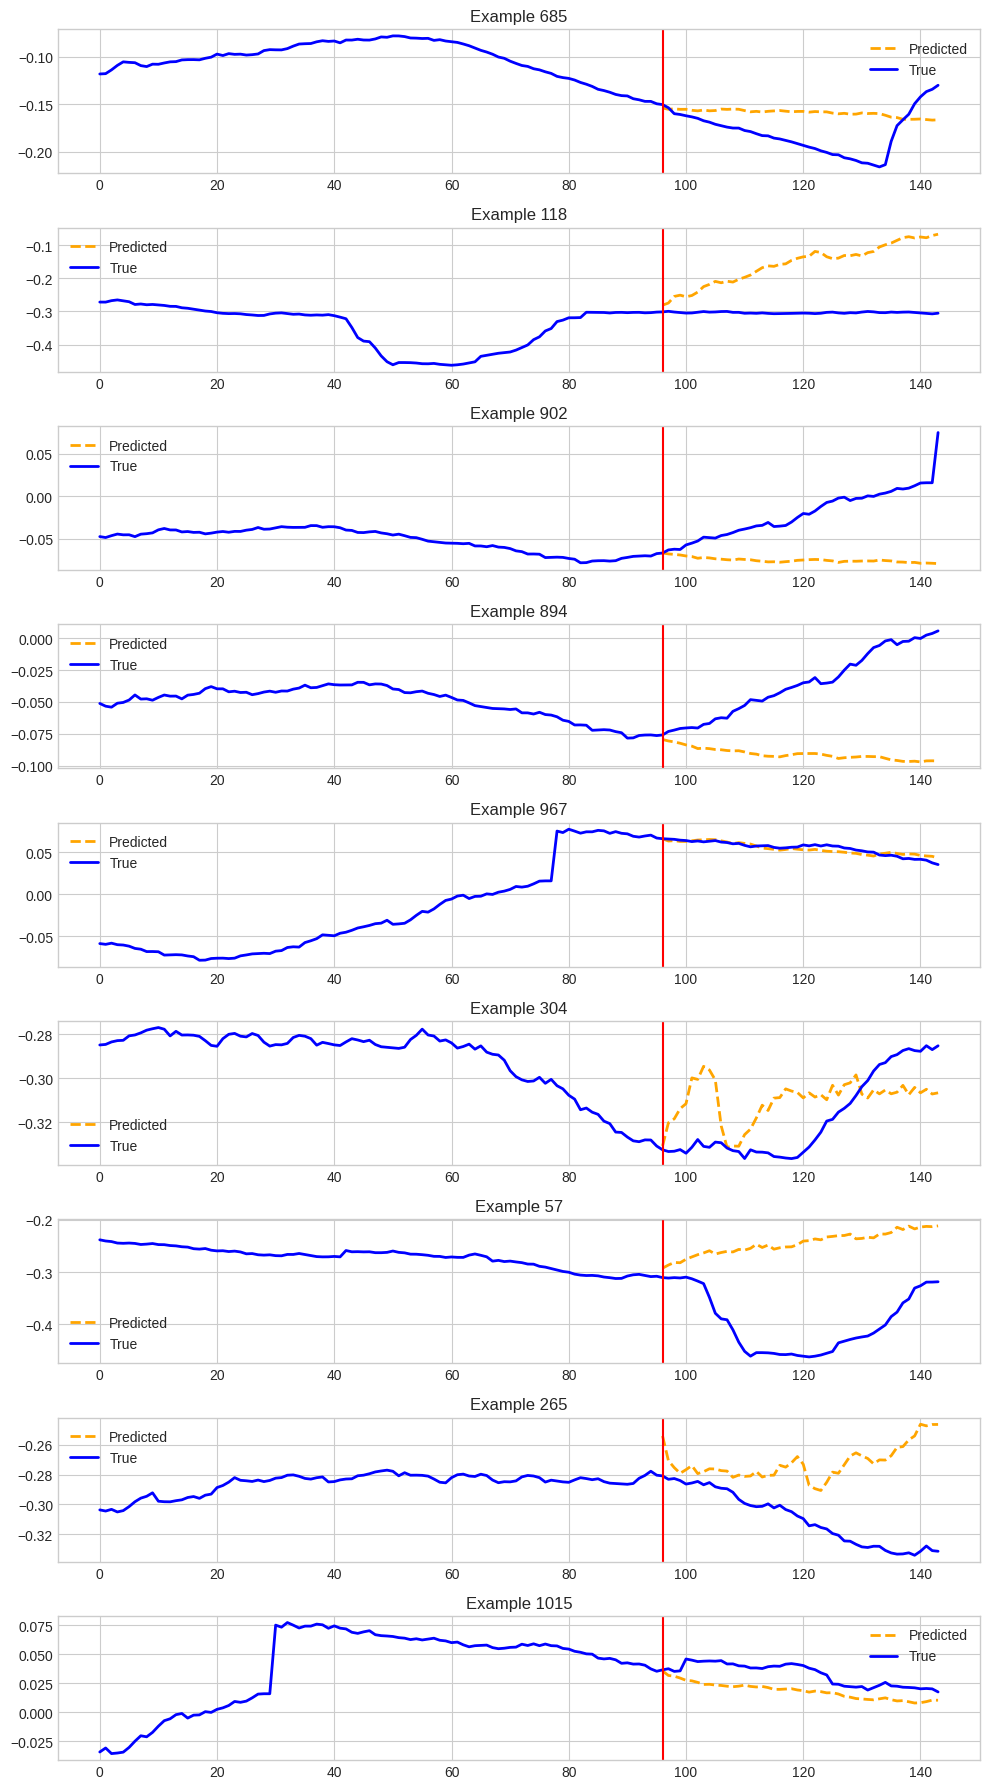

In [23]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

INFO:p-10215:t-129746807798656:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-10215:t-129746807798656:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-10215:t-129746807798656:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96
INFO:p-10215:t-129746807798656:lr_finder.py:optimal_lr_finder:LR Finder: Running learning rate (LR) finder algorithm. If the suggested LR is very low, we suggest setting the LR manually.
INFO:p-10215:t-129746807798656:lr_finder.py:optimal_lr_finder:LR Finder: Using GPU:0.
INFO:p-10215:t-129746807798656:lr_finder.py:optimal_lr_finder:LR Finder: Suggested learning rate = 9.770099572992256e-05


OPTIMAL SUGGESTED LEARNING RATE = 9.770099572992256e-05
Using learning rate = 9.770099572992256e-05


Checkpoint destination directory ttm_finetuned_models/PSM/output/checkpoint-22 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[TrackingCallback] Mean Epoch Time = 3.392817735671997 seconds, Total Train Time = 72.43065190315247
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.8606430292129517, 'eval_runtime': 3.2019, 'eval_samples_per_second': 609.953, 'eval_steps_per_second': 9.682, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1953, 48, 25)
(1953, 25, 12, 384)


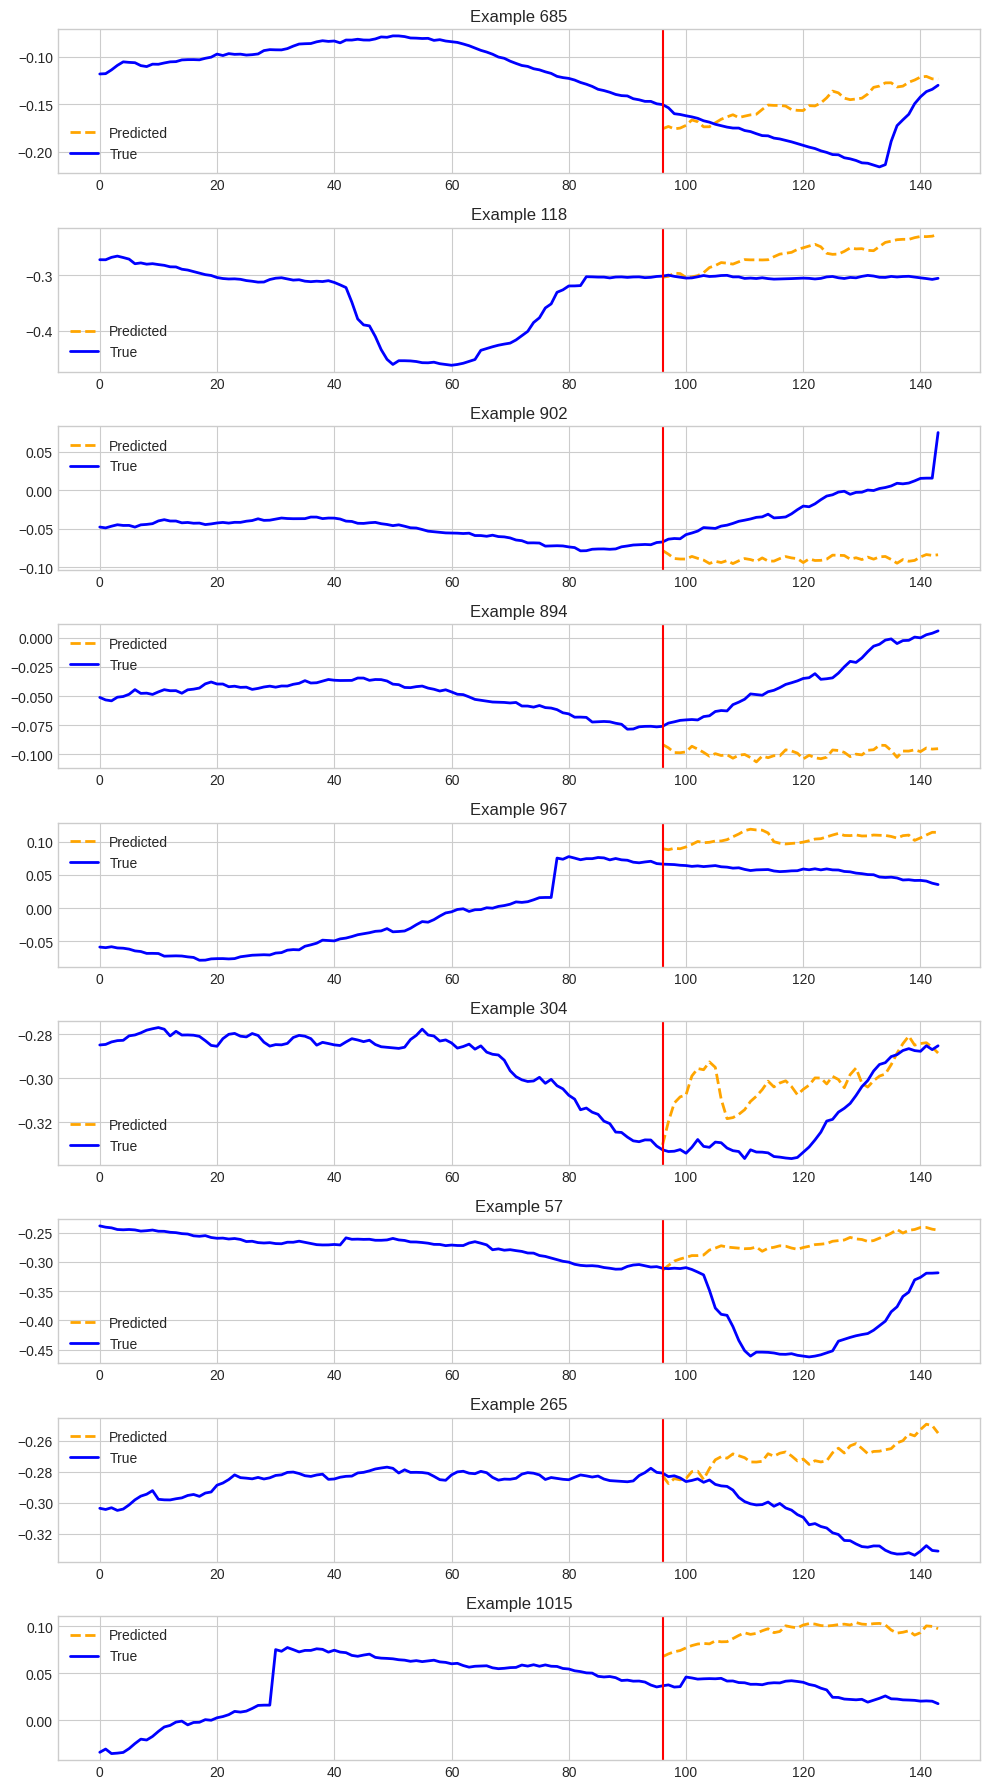

In [24]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)

INFO:p-21210:t-139022815595392:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 50% --------------------


INFO:p-21210:t-139022815595392:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-21210:t-139022815595392:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 10.832158503709016 seconds, Total Train Time = 333.03585982322693
++++++++++++++++++++ Test MSE after few-shot 50% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.23195473849773407, 'eval_runtime': 1.3348, 'eval_samples_per_second': 1427.142, 'eval_steps_per_second': 22.475, 'epoch': 27.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


[Debug] preds shape: (1905, 96, 25), targets shape: (1905, 96, 25)


(array([[[ 0.37337363, -0.8305019 , -0.9745062 , ...,  0.40413618,
          -0.23436153, -0.38650608],
         [ 0.3683281 , -0.8313495 , -0.97492164, ...,  0.40489376,
          -0.2684942 , -0.4063729 ],
         [ 0.36299992, -0.8317295 , -0.97916204, ...,  0.36692488,
          -0.29168522, -0.42899114],
         ...,
         [ 0.3813308 , -0.827719  , -0.9070209 , ...,  0.35752213,
           0.18026912,  0.14068353],
         [ 0.3852837 , -0.82685935, -0.90923804, ...,  0.34661162,
           0.19259322,  0.15369582],
         [ 0.38553965, -0.8277981 , -0.90424955, ...,  0.3914672 ,
           0.19690049,  0.1747272 ]],
 
        [[ 0.37603554, -0.8306644 , -0.9711535 , ...,  0.3197323 ,
          -0.04721868, -0.4191202 ],
         [ 0.37045383, -0.8314135 , -0.9721709 , ...,  0.33195364,
          -0.1035096 , -0.43140298],
         [ 0.36458415, -0.83201945, -0.97529584, ...,  0.32205534,
          -0.14567089, -0.43984216],
         ...,
         [ 0.38746512, -0.8280313

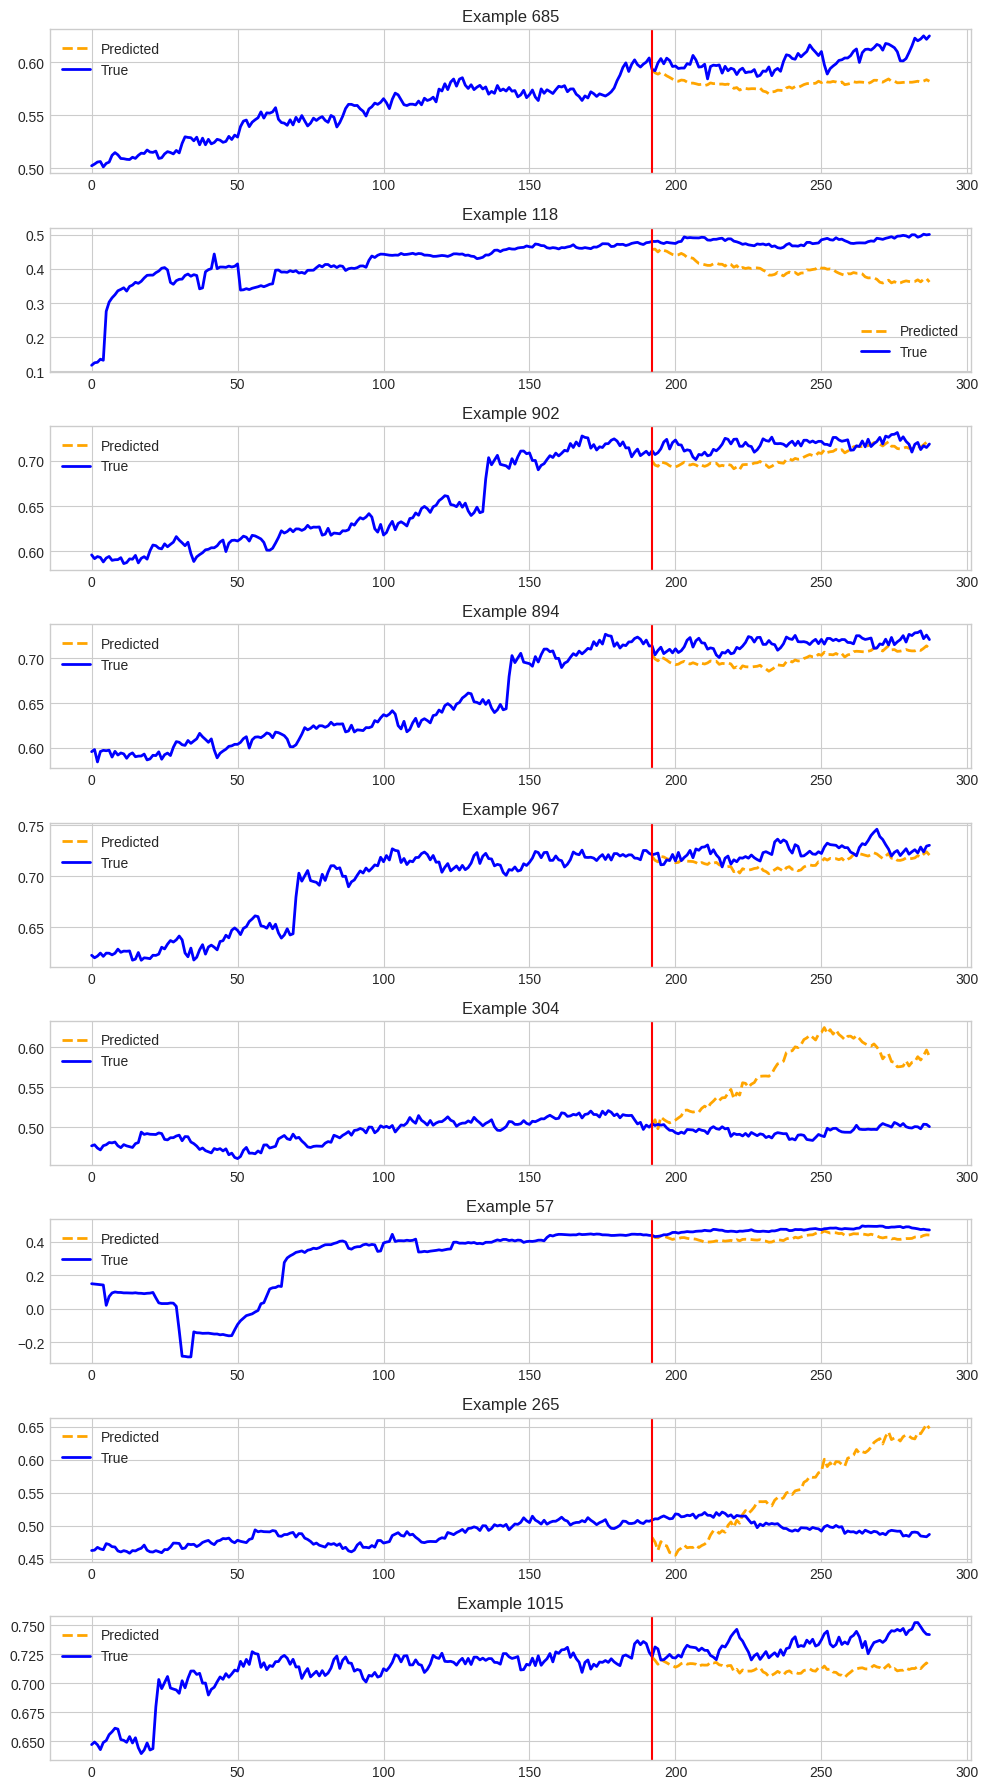

In [8]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=50,
    learning_rate=0.001,
)

In [9]:
labels = data.iloc[:, -1].values

INFO:p-21210:t-139022815595392:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 10% --------------------


INFO:p-21210:t-139022815595392:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-21210:t-139022815595392:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 2.4708609147505327 seconds, Total Train Time = 43.714155197143555
++++++++++++++++++++ Test MSE after few-shot 10% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2199140191078186, 'eval_runtime': 1.4958, 'eval_samples_per_second': 1273.583, 'eval_steps_per_second': 20.056, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(1905, 96, 25)
(1905, 25, 8, 192)


[Debug] preds shape: (1905, 96, 25), targets shape: (1905, 96, 25)


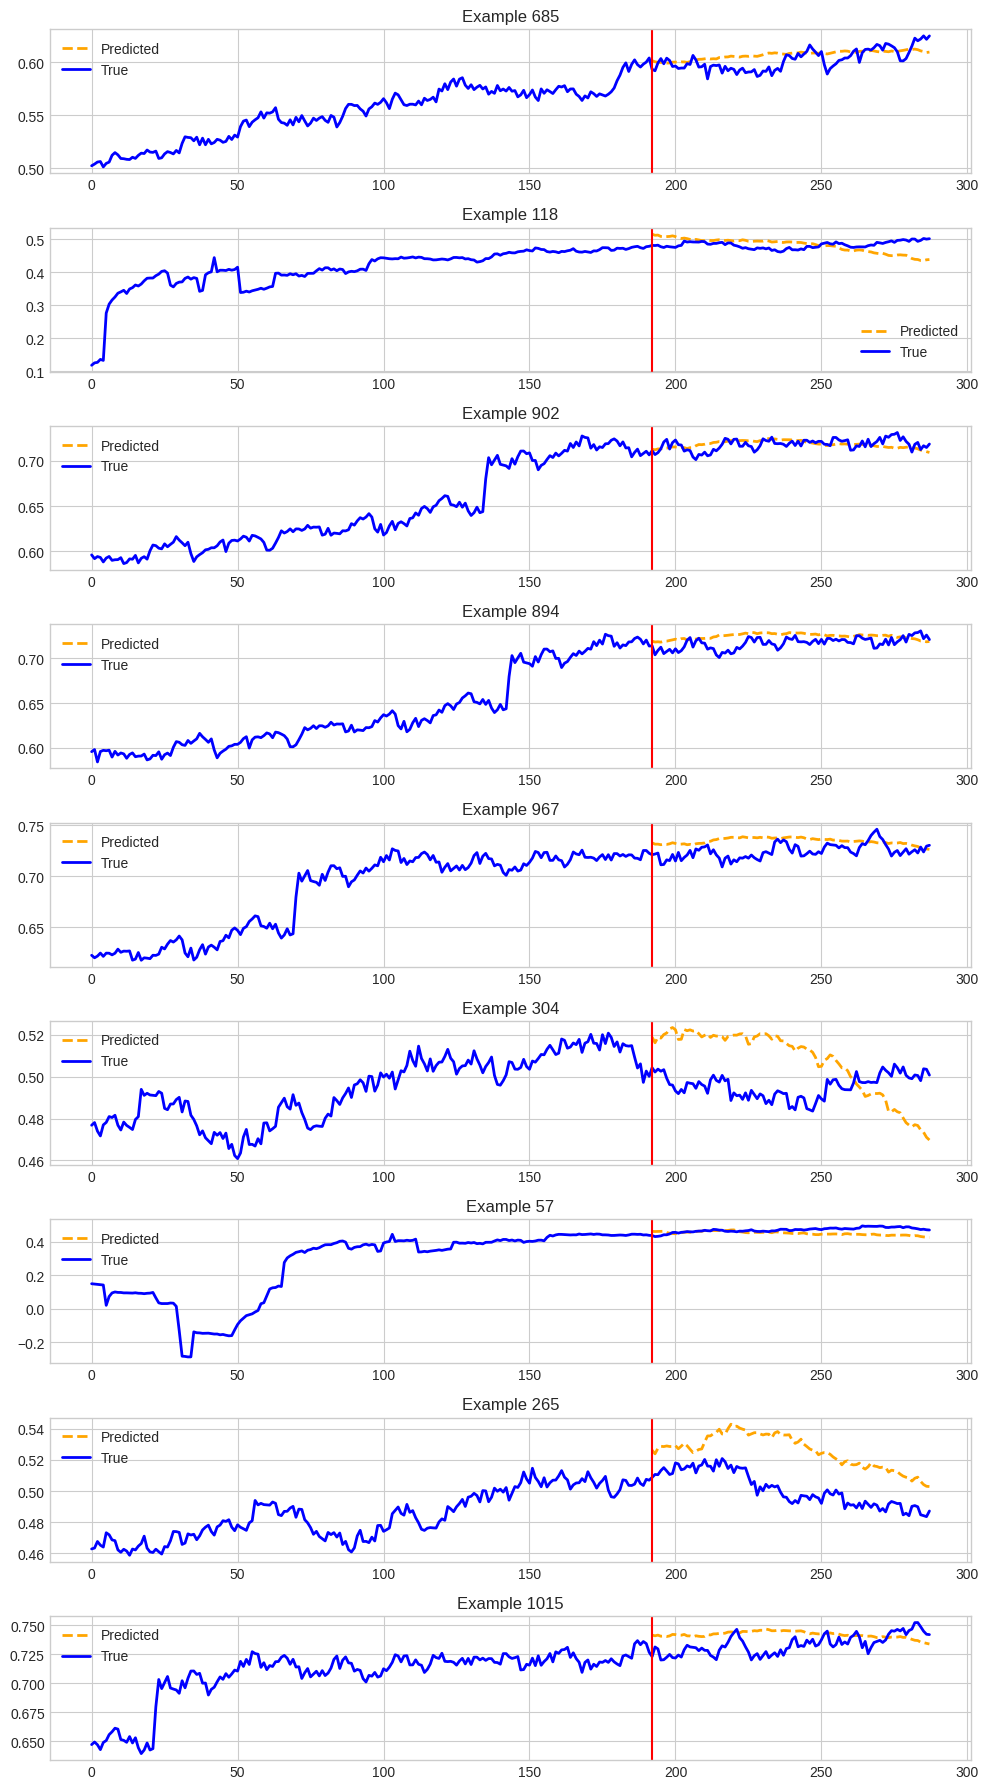

In [12]:
preds, targets = fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=10,
    learning_rate=0.001,
)

In [13]:
import numpy as np
raw_scores = np.mean(np.abs(preds - targets), axis=(1, 2))  # shape: (n_predictions,)

In [14]:
padded_scores = np.zeros_like(labels, dtype=float)
padding = len(labels) - len(raw_scores)
padded_scores[padding:] = raw_scores

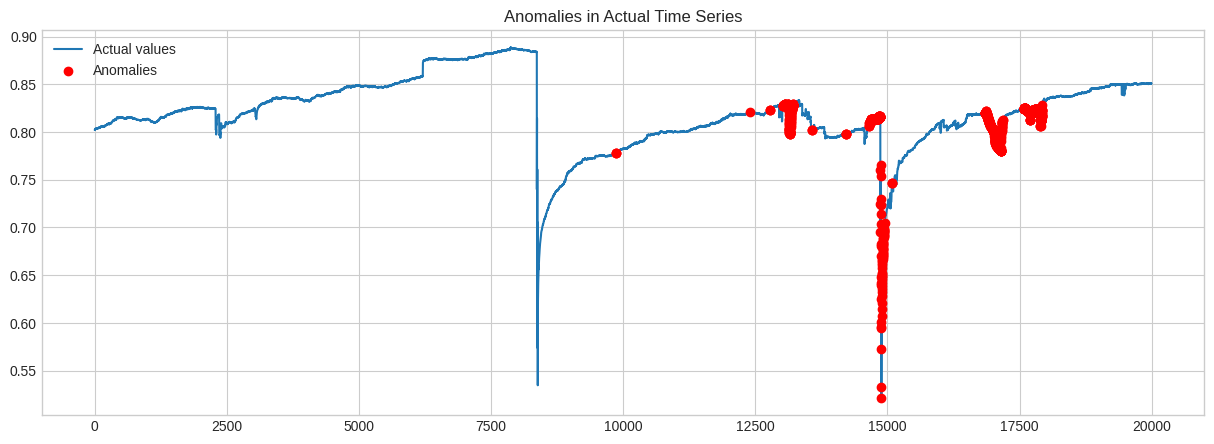

In [15]:
import matplotlib.pyplot as plt

channel = 0  # feature index to visualize
actuals = data.iloc[:, channel].values

plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual values')
plt.scatter(np.where(labels == 1), actuals[labels == 1], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.title('Anomalies in Actual Time Series')
plt.show()

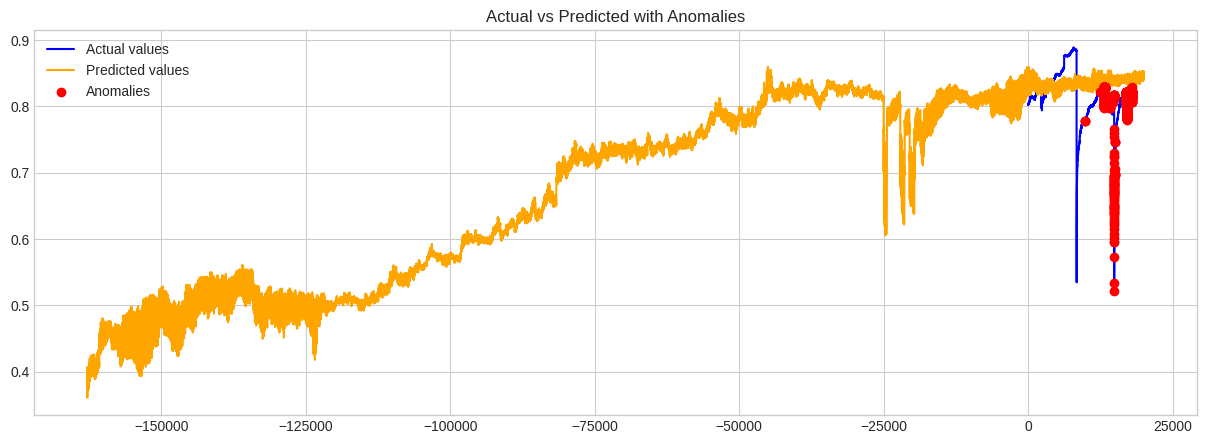

In [16]:
# Reconstruct predicted values (flatten if needed)
pred_series = preds[:, :, channel].flatten()
target_series = targets[:, :, channel].flatten()

plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual values', color='blue')
plt.plot(range(len(actuals) - len(pred_series), len(actuals)), pred_series, label='Predicted values', color='orange')
plt.scatter(np.where(labels == 1), actuals[labels == 1], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.title('Actual vs Predicted with Anomalies')
plt.show()